In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_OG = pd.read_csv("/Users/mac/Desktop/Downloads/bank+marketing/bank-additional/bank-additional-full.csv", sep=";")

# Display first few rows
print(df_OG.columns)
print(df_OG.shape)

df_OG.head(2)


Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')
(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# **Marketing Campaign Response Prediction**

## ** Problem Statement**
Predict whether a customer will subscribe to a **term deposit** after a marketing campaign, based on their **demographics, past interactions, and economic indicators**.

## ** Dataset Description**
### ** Input Variables**
#### **1. Bank Client Data**
| Feature | Description | Type |
|---------|------------|------|
| `age` | Age of the client | Numeric |
| `job` | Type of job | Categorical |
| `marital` | Marital status | Categorical |
| `education` | Education level | Categorical |
| `default` | Has credit in default? | Categorical |
| `housing` | Has housing loan? | Categorical |
| `loan` | Has personal loan? | Categorical |

#### **2. Last Contact Information**
| Feature | Description | Type |
|---------|------------|------|
| `contact` | Communication type | Categorical |
| `month` | Last contact month | Categorical |
| `day_of_week` | Last contact day | Categorical |
| `duration` | Call duration (benchmark only) | Numeric |

#### **3. Campaign & Previous Contact Details**
| Feature | Description | Type |
|---------|------------|------|
| `campaign` | Number of contacts in this campaign | Numeric |
| `pdays` | Days since last contact (999 = never contacted) | Numeric |
| `previous` | Number of past contacts | Numeric |
| `poutcome` | Outcome of the last campaign | Categorical |

#### **4. Social & Economic Indicators**
| Feature | Description | Type |
|---------|------------|------|
| `emp.var.rate` | Employment variation rate | Numeric |
| `cons.price.idx` | Consumer price index | Numeric |
| `cons.conf.idx` | Consumer confidence index | Numeric |
| `euribor3m` | 3-month Euribor rate | Numeric |
| `nr.employed` | Number of employees | Numeric |

---

## ** Target Variable**
| Feature | Description | Type |
|---------|------------|------|
| `y` | Has the client subscribed to a term deposit? | Binary (`yes`/`no`) |

---

## ** Machine Learning Pipeline**
1. **Data Preprocessing**
   - Handle missing values
   - Encode categorical variables (One-Hot Encoding)
   - Standardize numeric variables
   - Drop the `duration` column (for realistic prediction)

2. **Train-Test Split**
   - 80% training, 20% testing
   
3. **Train Models**
   - **Random Forest Classifier**
   - **XGBoost Classifier**
   - **Compare Performance Metrics**

4. **Evaluate Model**
   - Accuracy, ROC-AUC Score
   - Feature Importance Analysis
   - Hyperparameter Tuning with GridSearchCV

---

## ** Tools & Libraries**
- `Jupyter Notebook`, `Python`
- `pandas`, `numpy`
- `matplotlib`, `seaborn`
- `scikit-learn` (for model training & evaluation)

---

## ** Expected Outcome**
A model that can accurately predict whether a client will **subscribe to a term deposit**, helping banks **optimize marketing strategies**.

---


In [3]:
# Display basic info
print("Dataset Info:")
df_OG.info()

# Check missing values
print("\nMissing Values:")
print(df_OG.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
print(df_OG.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   4

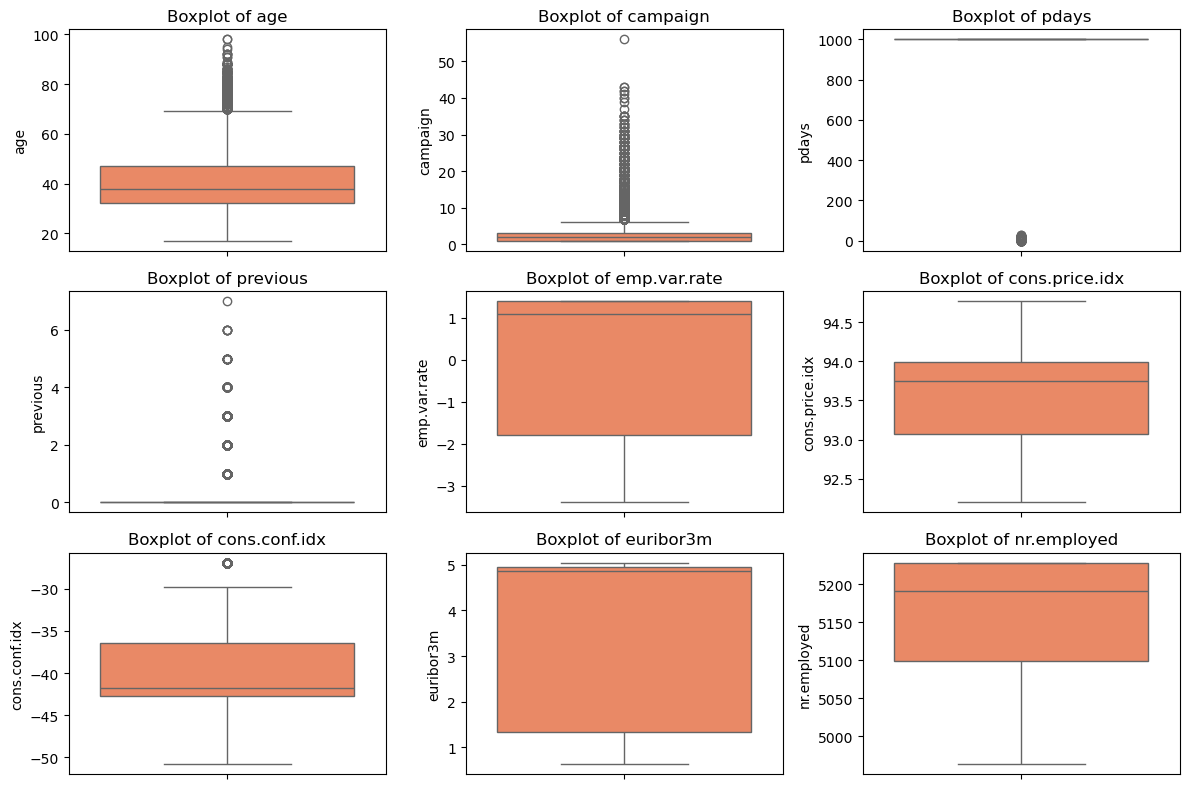

In [4]:
# List of numerical columns to check for outliers
numerical_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                  'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Boxplots for Outlier Detection (Numerical Features)
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df_OG[col], color="coral")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()



In [5]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, numerical_cols):
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile range
        
        # Define the bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove rows outside the acceptable range
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Remove outliers
df = remove_outliers_iqr(df_OG, numerical_cols)

# Display before & after dataset shape
print(f"Original dataset shape: {df_OG.shape}")
print(f"Cleaned dataset shape: {df.shape}")

Original dataset shape: (41188, 21)
Cleaned dataset shape: (24919, 21)


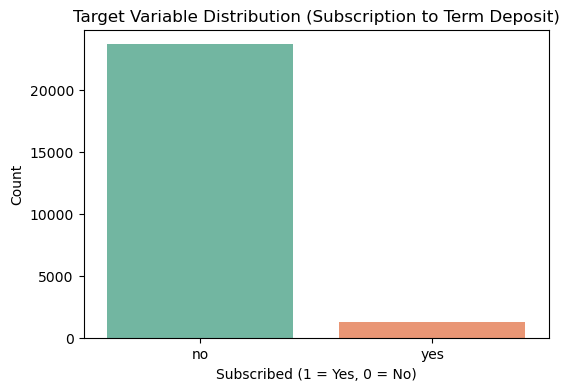

In [6]:

# Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=df, palette="Set2", hue = df['y'])
plt.title("Target Variable Distribution (Subscription to Term Deposit)")
plt.xlabel("Subscribed (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()


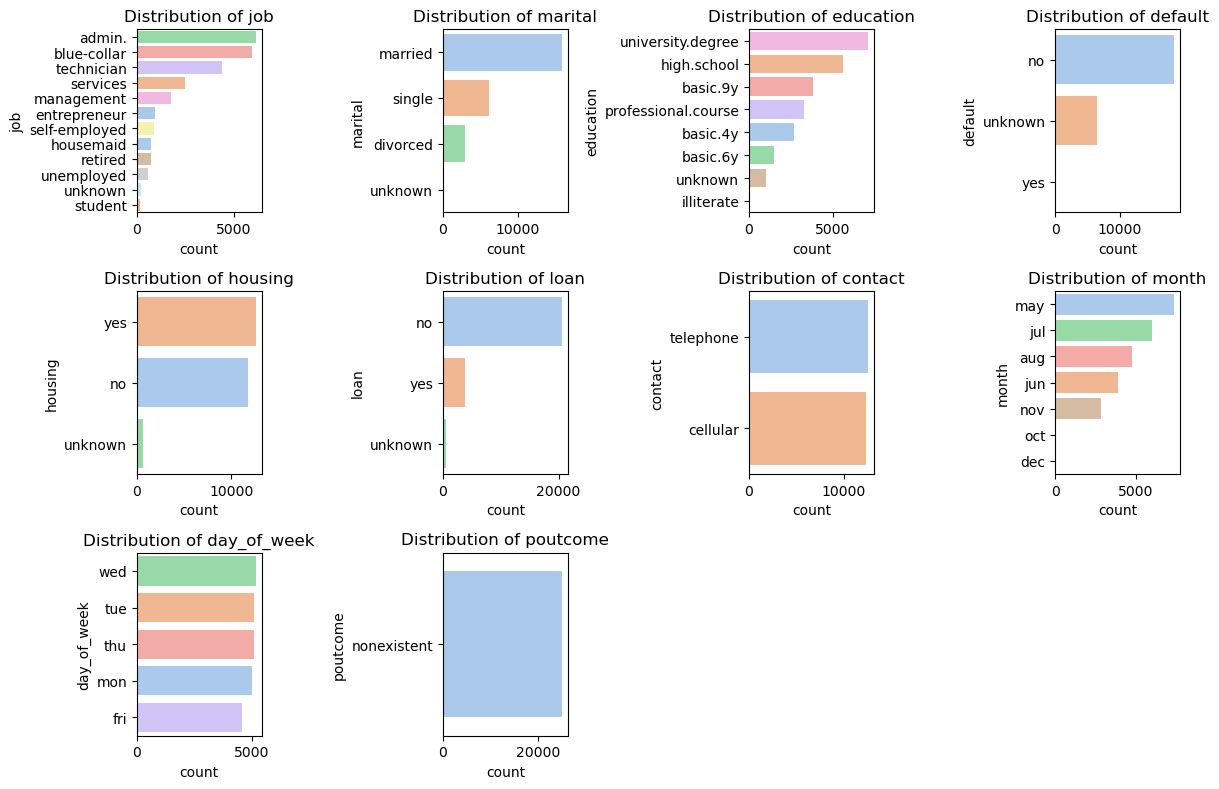

In [7]:

# Categorical Feature Analysis
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                    'contact', 'month', 'day_of_week', 'poutcome']

plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 4, i)
    sns.countplot(y=col, data=df, hue=df[col], palette="pastel", order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()



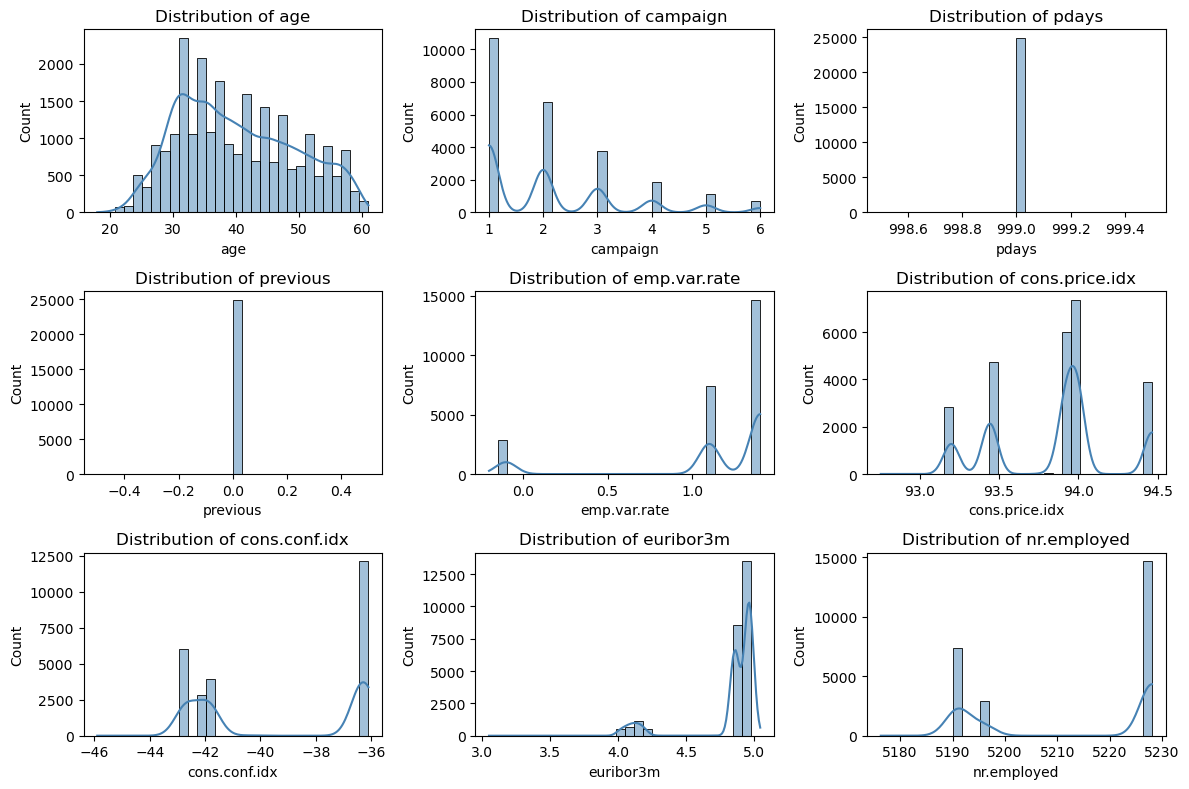

In [8]:
# Numerical Feature Distribution
numerical_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                  'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=30, kde=True, color="steelblue")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()



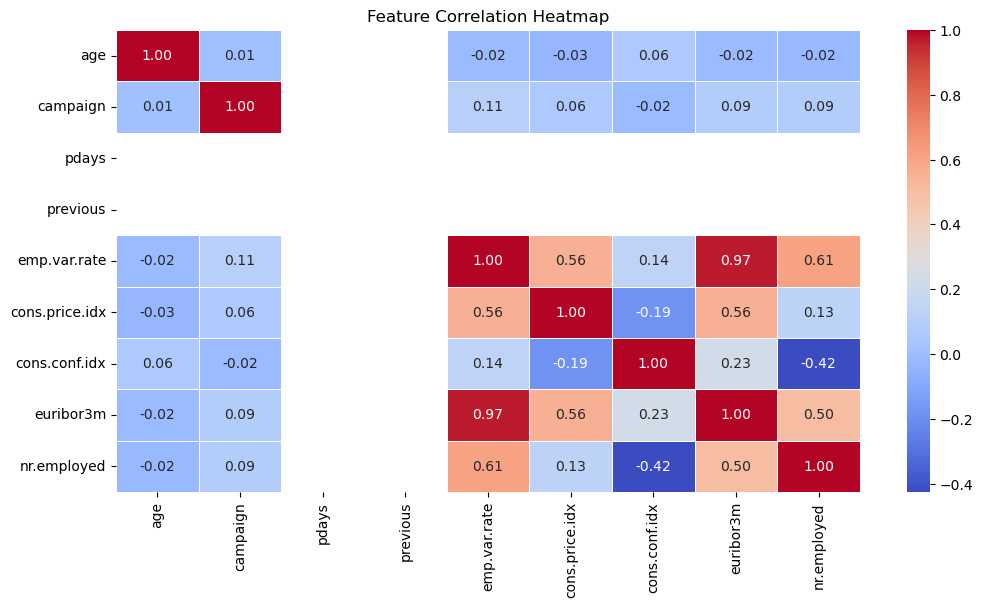

In [9]:
# Correlation Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()



In [10]:
# Convert target variable to binary (0 = no, 1 = yes)
df['y_yes'] = df['y'].map({'yes': 1, 'no': 0})


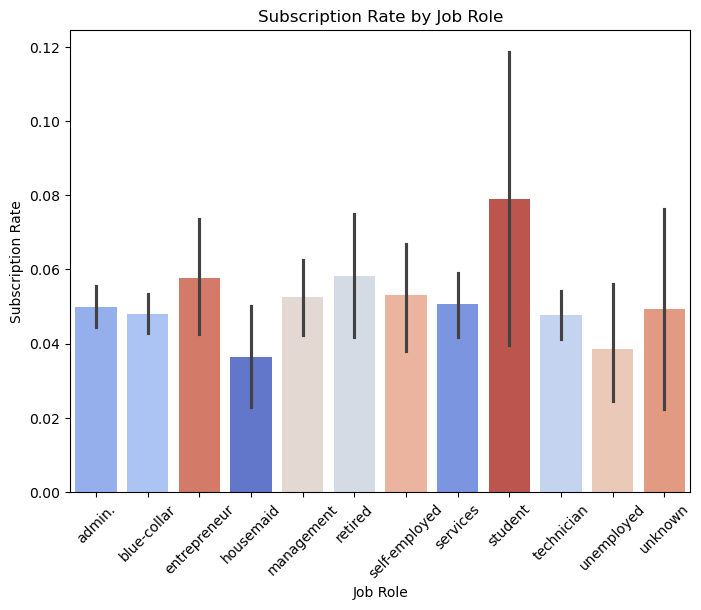

In [11]:
# Subscription Rate by Job Role
plt.figure(figsize=(8, 6))
sns.barplot(x=df['job'], y=df['y_yes'], hue=df['job'], palette="coolwarm", order=df.groupby('job')['y_yes'].mean().index)
plt.xticks(rotation=45)
plt.title("Subscription Rate by Job Role")
plt.xlabel("Job Role")
plt.ylabel("Subscription Rate")
plt.show()

In [12]:
print(df['y_yes'].dtype)
df = df.drop(columns=['y_yes'])

int64


In [13]:
# Handling categorical features
categorical_cols = df.select_dtypes(include=["object"]).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [14]:
# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
age                              0
duration                         0
campaign                         0
pdays                            0
previous                         0
emp.var.rate                     0
cons.price.idx                   0
cons.conf.idx                    0
euribor3m                        0
nr.employed                      0
job_blue-collar                  0
job_entrepreneur                 0
job_housemaid                    0
job_management                   0
job_retired                      0
job_self-employed                0
job_services                     0
job_student                      0
job_technician                   0
job_unemployed                   0
job_unknown                      0
marital_married                  0
marital_single                   0
marital_unknown                  0
education_basic.6y               0
education_basic.9y               0
education_high.school            0
education_illiterate             0
edu

In [15]:
# Define features and target variable
X = df.drop(columns=["y_yes"])  # Remove target column
y = df["y_yes"]  # Target column (binary classification)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Train an XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predictions
rf_preds = rf_model.predict(X_test_scaled)
xgb_preds = xgb_model.predict(X_test_scaled)

# Model Evaluation
print("\nRandom Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))

print("\nRandom Forest ROC-AUC Score:", roc_auc_score(y_test, rf_preds))
print("XGBoost ROC-AUC Score:", roc_auc_score(y_test, xgb_preds))


Random Forest Accuracy: 0.951645264847512
XGBoost Accuracy: 0.9526484751203852

Random Forest ROC-AUC Score: 0.6004077641856382
XGBoost ROC-AUC Score: 0.6584977081960516


/var/folders/gf/yk384_2j3cg5g3t29vdv1xhc0000gn/T/ipykernel_73751/1944569143.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=best_feature_importances.Importance[:10], y=best_feature_importances.Feature[:10], palette="viridis")


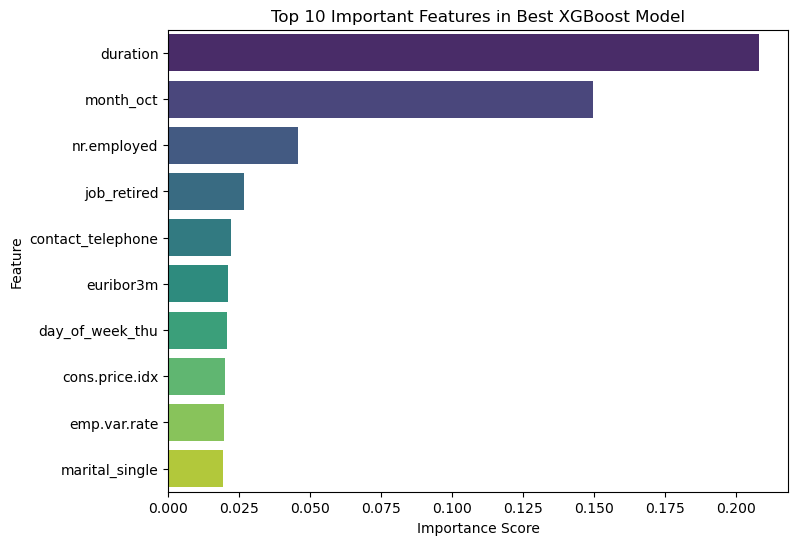

In [17]:

# Feature Importance for the best model
best_feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": xgb_model.feature_importances_})
best_feature_importances = best_feature_importances.sort_values(by="Importance", ascending=False)

# Plot Feature Importance for the best model
plt.figure(figsize=(8, 6))
sns.barplot(x=best_feature_importances.Importance[:10], y=best_feature_importances.Feature[:10], palette="viridis")
plt.title("Top 10 Important Features in Best XGBoost Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [18]:
# Cross-validation with accuracy as the scoring metric
cv_accuracy_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring="accuracy")
print(f"Cross-validation accuracy scores: {cv_accuracy_scores}")
print(f"Mean accuracy score from cross-validation: {cv_accuracy_scores.mean()}")


Cross-validation accuracy scores: [0.95284675 0.95209431 0.95159268 0.95510409 0.95209431]
Mean accuracy score from cross-validation: 0.9527464258841233


In [19]:

# Cross-validation with the best XGBoost model
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring="roc_auc")
print(f"Cross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean ROC-AUC score from cross-validation: {cv_scores.mean()}")


Cross-validation ROC-AUC scores: [0.96151641 0.95600364 0.96192492 0.96236021 0.96064765]
Mean ROC-AUC score from cross-validation: 0.96049056524579


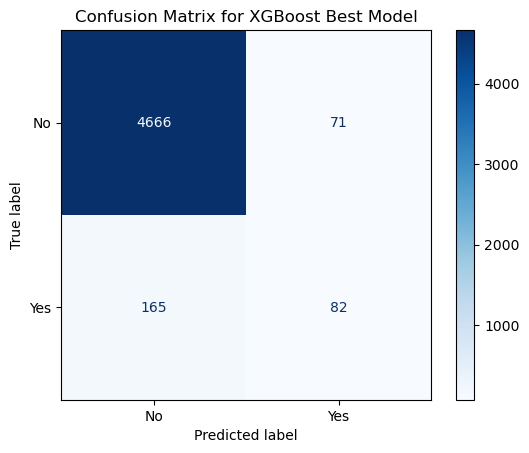

In [20]:

# Confusion matrix for the best XGBoost model
y_pred = xgb_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost Best Model")
plt.show()


In [21]:
# Hyperparameter tuning (XGBoost)
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=3, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (v

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best ROC-AUC Score: 0.9632135046152333


In [22]:
# Best parameters from grid search
best_params = grid_search.best_params_

# Retrain the XGBoost model with the best parameters
xgb_best_model = XGBClassifier(**best_params, random_state=42)
xgb_best_model.fit(X_train_scaled, y_train)

# Predictions
xgb_best_preds = xgb_best_model.predict(X_test_scaled)

# Model Evaluation with best model
print("\nXGBoost Best Model Accuracy:", accuracy_score(y_test, xgb_best_preds))
print("XGBoost Best Model ROC-AUC Score:", roc_auc_score(y_test, xgb_best_preds))



XGBoost Best Model Accuracy: 0.9556581059390048
XGBoost Best Model ROC-AUC Score: 0.6524060309100808


In [26]:
# Predictions (Probabilities for ROC-AUC)
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class
xgb_before_probs = xgb_model.predict_proba(X_test_scaled)[:, 1]
xgb_after_probs = xgb_best_model.predict_proba(X_test_scaled)[:, 1]


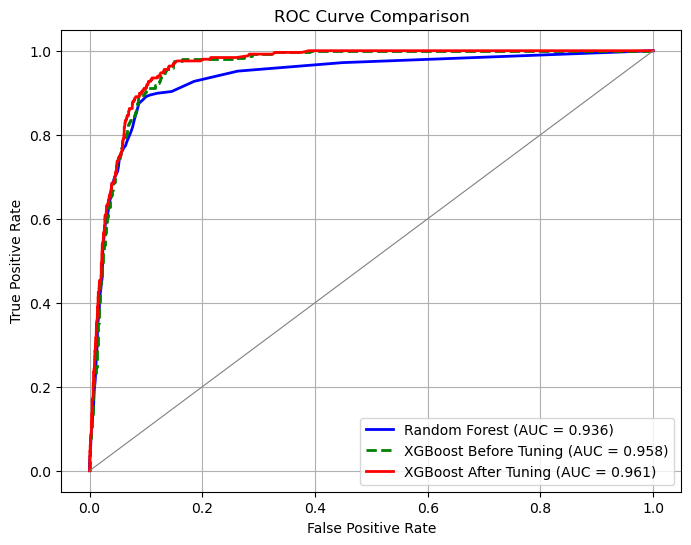

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you already have the true labels and predicted probabilities for each model:
# y_test -> True labels
# rf_probs -> Predicted probabilities from Random Forest
# xgb_before_probs -> Predicted probabilities from XGBoost before tuning
# xgb_after_probs -> Predicted probabilities from XGBoost after tuning

# Compute ROC curve and AUC score for each model
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb_before, tpr_xgb_before, _ = roc_curve(y_test, xgb_before_probs)
roc_auc_xgb_before = auc(fpr_xgb_before, tpr_xgb_before)

fpr_xgb_after, tpr_xgb_after, _ = roc_curve(y_test, xgb_after_probs)
roc_auc_xgb_after = auc(fpr_xgb_after, tpr_xgb_after)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f"Random Forest (AUC = {roc_auc_rf:.3f})")
plt.plot(fpr_xgb_before, tpr_xgb_before, color='green', lw=2, linestyle='--', 
         label=f"XGBoost Before Tuning (AUC = {roc_auc_xgb_before:.3f})")
plt.plot(fpr_xgb_after, tpr_xgb_after, color='red', lw=2, linestyle='-', 
         label=f"XGBoost After Tuning (AUC = {roc_auc_xgb_after:.3f})")

# Plot diagonal line (random guessing)
plt.plot([0, 1], [0, 1], color='gray',  lw=0.8)

# Labels, Title, and Legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()
